No results to display. Please check the strategy logic.
Result DataFrame is empty. Skipping visualization and metrics calculation.


/Users/luffy/Code/Anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/luffy/Code/Anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36164 (\N{CJK UNIFIED IDEOGRAPH-8D44}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/luffy/Code/Anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20135 (\N{CJK UNIFIED IDEOGRAPH-4EA7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/luffy/Code/Anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/luffy/Code/Anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Us

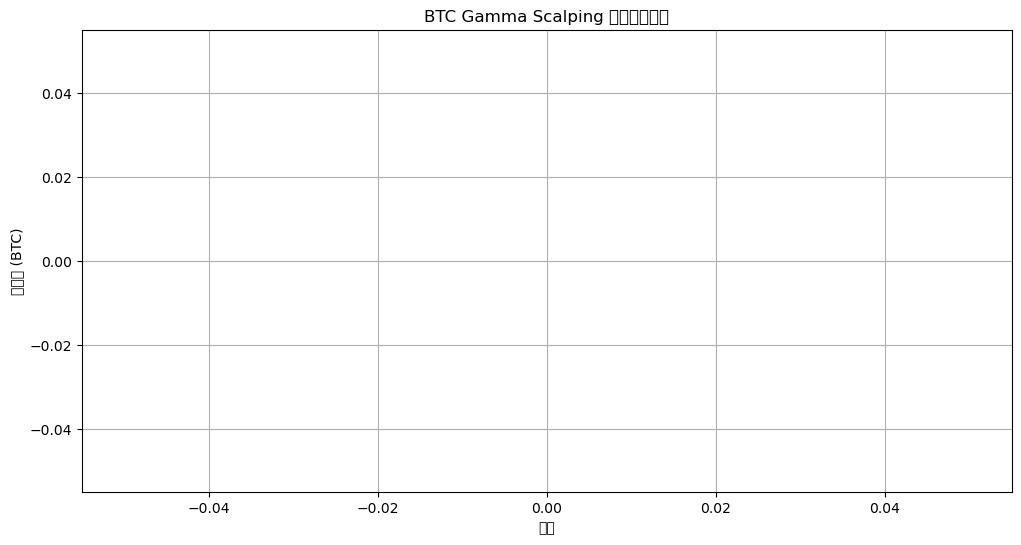

最大回撤: nan%
夏普比率: nan


In [6]:
# BTC Gamma Scalping 回测可视化

import os
import pandas as pd
import matplotlib.pyplot as plt
from data_loader import DataLoader
from engine import GammaScalping

# 参数设置
params = {
    "start_date": "2025-04-24",
    "end_date": "2025-12-31",
    "initial_capital": 1.0,
    "hedge_freq_days": 2
}

# 数据加载
file_path = "data.csv"
if not os.path.exists(file_path):
    sample_data = {
        "Date": pd.date_range(start=params["start_date"], end=params["end_date"], freq="B"),
        "Price": [10000 + i * 10 for i in range(len(pd.date_range(start=params["start_date"], end=params["end_date"], freq="B")))],
        "Expiry": [None] * len(pd.date_range(start=params["start_date"], end=params["end_date"], freq="B"))
    }
    sample_df = pd.DataFrame(sample_data)
    sample_df.to_csv(file_path, index=False)
    print(f"Sample data created and saved to {file_path}")

loader = DataLoader(file_path)
expiry = loader.get_third_friday(2025, 4)
df = loader.add_expiry_days(expiry)

# 策略初始化
engine = GammaScalping(df, params["initial_capital"], params["hedge_freq_days"])

results = []
for idx, row in df.iterrows():
    today = row['Date'].date()
    # 到期日建仓
    if today == row['Expiry']:
        if engine.current_position:
            engine.close_position(row)
        try:
            engine.open_position(row)
        except RuntimeError as e:
            print(f"建仓失败: {e}")
            continue
    # 对冲
    if engine.current_position and (engine.last_hedge_day is None or (today - engine.last_hedge_day).days >= params["hedge_freq_days"]):
        call_delta, put_delta, perp_delta, total_delta = engine.delta_hedging(row, today)
    else:
        call_delta = put_delta = perp_delta = total_delta = 0.0
    # 组合跟踪
    if engine.current_position:
        record = engine.track_portfolio(row, call_delta, put_delta, perp_delta, total_delta)
        if record:  # Ensure the record is not None or empty
            results.append(record)

if results:
    result_df = pd.DataFrame(results)
    display(result_df)
else:
    print("No results to display. Please check the strategy logic.")
    # Create a placeholder DataFrame with necessary columns to avoid KeyError
    result_df = pd.DataFrame(columns=['Date', 'TotalAsset'])

# Ensure result_df is not empty before plotting or calculating metrics
if not result_df.empty:
    # 净值曲线
    plt.figure(figsize=(12, 6))
    # 检查日期列名是否为 'date' 而不是 'Date'
    plt.plot(result_df.index if 'Date' not in result_df.columns else result_df['Date'], 
             result_df['TotalAsset'])
    plt.title("BTC Gamma Scalping 策略净值曲线")
    plt.xlabel("日期")
    plt.ylabel("总资产 (BTC)")
    plt.grid()
    plt.show()

    # 最大回撤
    roll_max = result_df['TotalAsset'].cummax()
    drawdown = (result_df['TotalAsset'] - roll_max) / roll_max
    max_drawdown = drawdown.min()
    print(f"最大回撤: {max_drawdown:.2%}")

    # 夏普比率
    returns = result_df['TotalAsset'].pct_change().dropna()
    sharpe = returns.mean() / returns.std() * (252 ** 0.5)
    print(f"夏普比率: {sharpe:.2f}")
else:
    print("Result DataFrame is empty. Skipping visualization and metrics calculation.")

# 净值曲线
plt.figure(figsize=(12, 6))
# 检查日期列名是否为 'date' 而不是 'Date'
plt.plot(result_df.index if 'Date' not in result_df.columns else result_df['Date'], 
         result_df['TotalAsset'])
plt.title("BTC Gamma Scalping 策略净值曲线")
plt.xlabel("日期")
plt.ylabel("总资产 (BTC)")
plt.grid()
plt.show()

# 最大回撤
roll_max = result_df['TotalAsset'].cummax()
drawdown = (result_df['TotalAsset'] - roll_max) / roll_max
max_drawdown = drawdown.min()
print(f"最大回撤: {max_drawdown:.2%}")

# 夏普比率
returns = result_df['TotalAsset'].pct_change().dropna()
sharpe = returns.mean() / returns.std() * (252 ** 0.5)
print(f"夏普比率: {sharpe:.2f}")